In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from sklearn.model_selection import KFold

import training_utils


In [2]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
img_size = (240, 320)
img_channels = 3
batch_size = 8
epochs = 100
display_epochs = (0, 100)
inputs = keras.Input(shape= img_size + (img_channels,))


x_col_name = 0
y_col_name = 1

In [4]:
model_name = 'VGG16_(256).tf'
global_history= {}


In [5]:
dataset_path = r"C:\Users\olabr\OneDrive\AI datasets\jhu_crowd_v2.0"

In [6]:
callbacks_list = [
    #    keras.callbacks.EarlyStopping(
    #        monitor="val_loss", patience=4
    #    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    #   keras.callbacks.TensorBoard()
]

In [7]:
train_df = pd.read_csv(dataset_path + '/train/image_labels.txt', sep=',', header=None, dtype={0: str, 1: np.float32})
val_df = pd.read_csv(dataset_path + '/val/image_labels.txt', sep=',', header=None, dtype={0: str, 1: np.float32})
test_df = pd.read_csv(dataset_path + '/test/image_labels.txt', sep=',', header=None, dtype={0: str, 1: np.float32})

In [8]:
display(train_df.head())

,0,1,2,3,4
0,0001,161.0,water park,0,0
1,0008,855.0,marathon,0,0
2,0010,455.0,protest,0,0
3,0012,7139.0,stadium,0,0
4,0014,111.0,protest,0,0


In [9]:
train_df.columns

Index([0, 1, 2, 3, 4], dtype='int64')

In [10]:
train_df[0] = train_df[0].apply(lambda x: str(x) + '.jpg')
val_df[0] = val_df[0].apply(lambda x: str(x) + '.jpg')
test_df[0] = test_df[0].apply(lambda x: str(x) + '.jpg')

In [11]:
display(train_df.head())
display(val_df.head())
display(test_df.head())

,0,1,2,3,4
0,0001.jpg,161.0,water park,0,0
1,0008.jpg,855.0,marathon,0,0
2,0010.jpg,455.0,protest,0,0
3,0012.jpg,7139.0,stadium,0,0
4,0014.jpg,111.0,protest,0,0


,0,1,2,3,4
0,0003.jpg,804.0,street,0,0
1,0007.jpg,41.0,street,0,0
2,0009.jpg,26.0,street,1,0
3,0011.jpg,31.0,stadium,0,0
4,0013.jpg,5000.0,stadium,0,0


,0,1,2,3,4
0,0002.jpg,43.0,street,1,0
1,0004.jpg,59.0,street,0,0
2,0005.jpg,463.0,stadium,0,0
3,0006.jpg,299.0,conference,0,0
4,0016.jpg,140.0,rally,0,0


In [12]:
def load_single_generator(df, img_path='/frames/frames/', debug=False):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
        rescale=1. / 255,
    )
    if debug:
        display(df)
        print(x_col_name)
        print(y_col_name)

    print(''.join([dataset_path, img_path]))
    generator = datagen.flow_from_dataframe(
        df,
        ''.join([dataset_path, img_path]),
        x_col=x_col_name,
        y_col=y_col_name,
        class_mode='raw',
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
    )

    return generator


In [13]:
train_generator = load_single_generator(train_df, img_path='/train/images/')
val_generator = load_single_generator(val_df, img_path='/val/images/')
test_generator = load_single_generator(test_df, img_path='/test/images/')

C:\Users\olabr\OneDrive\AI datasets\jhu_crowd_v2.0/train/images/
Found 2272 validated image filenames.
C:\Users\olabr\OneDrive\AI datasets\jhu_crowd_v2.0/val/images/
Found 500 validated image filenames.
C:\Users\olabr\OneDrive\AI datasets\jhu_crowd_v2.0/test/images/
Found 1600 validated image filenames.


In [97]:
baseline_mae = np.mean(np.abs(test_df[1] - np.mean(test_df[1])))
print(f'Baseline MAE: {baseline_mae}')
baseline_mae = np.mean(np.abs(val_df[1] - np.mean(val_df[1])))
print(f'Baseline MAE: {baseline_mae}')
baseline_mae = np.mean(np.abs(train_df[1] - np.mean(train_df[1])))
print(f'Baseline MAE: {baseline_mae}')



Baseline MAE: 345.35308837890625
Baseline MAE: 332.0926818847656
Baseline MAE: 425.99920654296875


# Models

## Simple Covnet model

In [14]:
def basic_covnet_block():
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

In [99]:
covnet_block = basic_covnet_block()
x = layers.Flatten()(covnet_block)
x = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=x)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 240, 320, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 119, 159, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 59, 79, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 39, 128)       73856     
                                                                 
 flatten_5 (Flatten)         (None, 144768)            0         
                                                                 
 dense_5 (Dense)             (None, 1)                 144769    
                                                                 
Total params: 238,017
Trainable params: 238,017
Non-trainab

In [100]:
Wsave = model.get_weights()

In [101]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 1299126.0000 - mae: 403.6329

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 57s 2s/step - loss: 1299126.0000 - mae: 403.6329 - val_loss: 444166.7188 - val_mae: 368.0887
Epoch 2/100
36/36 [==============================] - 53s 1s/step - loss: 1238571.2500 - mae: 400.1386 - val_loss: 477709.0000 - val_mae: 529.0507
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 1191517.5000 - mae: 422.6487

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 54s 1s/step - loss: 1191517.5000 - mae: 422.6487 - val_loss: 345065.3125 - val_mae: 290.7973
Epoch 4/100
36/36 [==============================] - 53s 1s/step - loss: 1116862.2500 - mae: 382.8085 - val_loss: 380169.4062 - val_mae: 408.1239
Epoch 5/100
36/36 [==============================] - 52s 1s/step - loss: 1090058.8750 - mae: 397.1519 - val_loss: 377533.6250 - val_mae: 401.7678
Epoch 6/100
36/36 [==============================] - 52s 1s/step - loss: 1126794.8750 - mae: 371.4773 - val_loss: 363247.5938 - val_mae: 380.9231
Epoch 7/100
36/36 [==============================] - 52s 1s/step - loss: 1104585.7500 - mae: 380.6713 - val_loss: 349632.5625 - val_mae: 258.4426
Epoch 8/100
36/36 [==============================] - ETA: 0s - loss: 1065212.1250 - mae: 406.8612

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 52s 1s/step - loss: 1065212.1250 - mae: 406.8612 - val_loss: 339953.4062 - val_mae: 253.8107
Epoch 9/100
36/36 [==============================] - ETA: 0s - loss: 1053902.5000 - mae: 376.3609

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 52s 1s/step - loss: 1053902.5000 - mae: 376.3609 - val_loss: 339214.6875 - val_mae: 253.4656
Epoch 10/100
36/36 [==============================] - 51s 1s/step - loss: 1034985.8125 - mae: 375.0058 - val_loss: 379486.2188 - val_mae: 385.3617
Epoch 11/100
36/36 [==============================] - 54s 1s/step - loss: 1045215.5625 - mae: 389.6899 - val_loss: 370646.4688 - val_mae: 245.8876
Epoch 12/100
36/36 [==============================] - ETA: 0s - loss: 1031566.1875 - mae: 358.1649

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 60s 2s/step - loss: 1031566.1875 - mae: 358.1649 - val_loss: 335361.1875 - val_mae: 334.7568
Epoch 13/100
36/36 [==============================] - 67s 2s/step - loss: 1022645.0625 - mae: 377.2155 - val_loss: 368995.3750 - val_mae: 247.3410
Epoch 14/100
36/36 [==============================] - 60s 2s/step - loss: 984033.3750 - mae: 364.4683 - val_loss: 418412.4688 - val_mae: 406.1373
Epoch 15/100
36/36 [==============================] - ETA: 0s - loss: 1014119.4375 - mae: 371.9537

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 57s 2s/step - loss: 1014119.4375 - mae: 371.9537 - val_loss: 317055.1250 - val_mae: 286.1368
Epoch 16/100
36/36 [==============================] - 57s 2s/step - loss: 971173.3125 - mae: 374.2313 - val_loss: 334590.5938 - val_mae: 323.3373
Epoch 17/100
36/36 [==============================] - 56s 2s/step - loss: 949750.3125 - mae: 356.2682 - val_loss: 460748.8125 - val_mae: 423.1833
Epoch 18/100
36/36 [==============================] - ETA: 0s - loss: 968823.0000 - mae: 371.6872

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 57s 2s/step - loss: 968823.0000 - mae: 371.6872 - val_loss: 307496.9375 - val_mae: 260.8677
Epoch 19/100
36/36 [==============================] - 56s 2s/step - loss: 933640.3125 - mae: 367.2214 - val_loss: 314333.9062 - val_mae: 285.4496
Epoch 20/100
36/36 [==============================] - 56s 2s/step - loss: 942852.5625 - mae: 376.4810 - val_loss: 311128.4375 - val_mae: 264.7154
Epoch 21/100
36/36 [==============================] - 53s 1s/step - loss: 888726.8750 - mae: 335.9259 - val_loss: 479181.8438 - val_mae: 423.2965
Epoch 22/100
36/36 [==============================] - 51s 1s/step - loss: 904196.3750 - mae: 381.8956 - val_loss: 313445.6562 - val_mae: 270.8719
Epoch 23/100
36/36 [==============================] - 51s 1s/step - loss: 904702.9375 - mae: 349.4100 - val_loss: 406675.7812 - val_mae: 356.8569
Epoch 24/100
36/36 [==============================] - 51s 1s/step - loss: 833443.3750 - mae: 353.4187 - val_loss: 309578.3750 - val_mae: 

In [102]:
global_history['simple_covnet_(32_64_128)_()'] = history

Min mae: 196.07850646972656
Min val_mae: 245.88760375976562
Min loss: 93519.890625
Min val_loss: 307496.9375


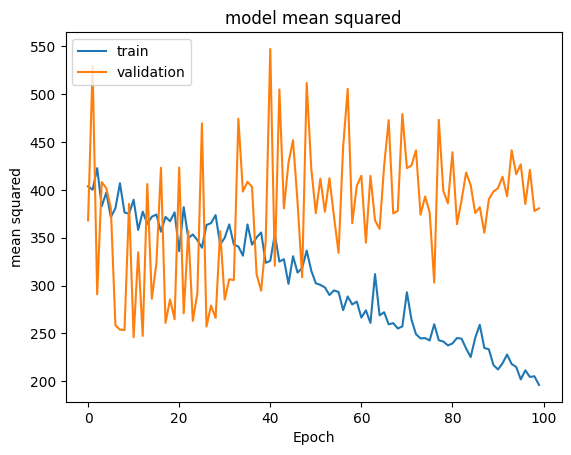

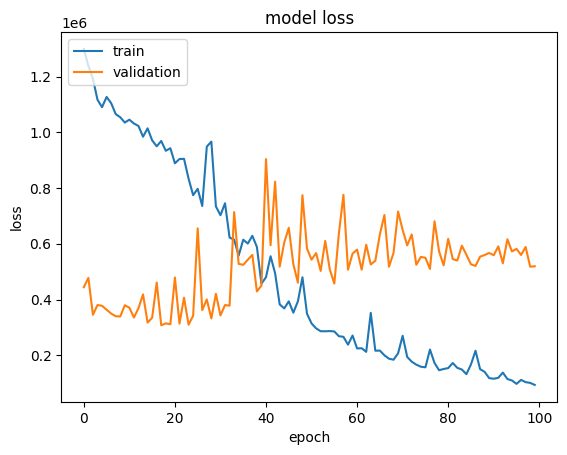

In [103]:
training_utils.history_metric_evaluation(history, display_epochs)

## Depthwise model

In [14]:
def custom_depthwise_conv_block(input, sizes, repeat_per_size, stride=1, pooling=False, dropout=False, residual=False):
    x = input

    previous_block_activation = x

    for size in sizes:
        for i in range(repeat_per_size - 1):
            x = layers.BatchNormalization()(x)
            x = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        if dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.SeparableConv2D(size, 3, strides=1 if pooling else stride, padding='same', use_bias=False)(x)
        if pooling:
            x = layers.MaxPooling2D(3, strides=stride, padding='same')(x)
        if residual:
            r = layers.SeparableConv2D(size, 1, strides=stride, padding="same")(
                previous_block_activation
            )
            x = layers.add([x, r])
            previous_block_activation = x

    return x

In [15]:
def basic_dense_block(covnet_param, sizes, global_pooling=False):
    if global_pooling:
        x = layers.GlobalAveragePooling2D()(covnet_param)
    else:
        x = layers.Flatten()(covnet_param)
    x = layers.Dropout(0.5)(x)
    for size in sizes:
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return outputs

### Basic depthwise model

#### Single Output dense layer

In [106]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, stride=2)
outputs = basic_dense_block(covnet, [])
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [107]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 240, 320, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 240, 320, 3)      12        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 240, 320, 3)       0         
                                                                 
 separable_conv2d (Separable  (None, 240, 320, 32)     123       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 240, 320, 32)     128       
 hNormalization)                                                 
                                                           

In [108]:
Wsave = model.get_weights()

In [109]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
36/36 [==============================] - 53s 1s/step - loss: 1229905.7500 - mae: 376.3428 - val_loss: 535887.2500 - val_mae: 290.5833
Epoch 2/100
36/36 [==============================] - 50s 1s/step - loss: 1003706.2500 - mae: 341.3051 - val_loss: 539164.4375 - val_mae: 296.0990
Epoch 3/100
36/36 [==============================] - 50s 1s/step - loss: 933205.1250 - mae: 355.5987 - val_loss: 540302.5625 - val_mae: 298.0143
Epoch 4/100
36/36 [==============================] - 50s 1s/step - loss: 895999.5000 - mae: 355.0871 - val_loss: 538388.5000 - val_mae: 294.7860
Epoch 5/100
36/36 [==============================] - 50s 1s/step - loss: 818174.8125 - mae: 359.9723 - val_loss: 537863.5000 - val_mae: 293.9725
Epoch 6/100
36/36 [==============================] - 51s 1s/step - loss: 762850.5625 - mae: 324.3212 - val_loss: 533949.1875 - val_mae: 287.4680
Epoch 7/100
36/36 [==============================] - 51s 1s/step - loss: 818170.5625 - mae: 382.4924 - val_loss: 511219.7500 - v

In [110]:
global_history['depthwise_covnet_(32_64_128)_()'] = history

Min mae: 99.19595336914062
Min val_mae: 260.7049560546875
Min loss: 21598.21875
Min val_loss: 337170.5


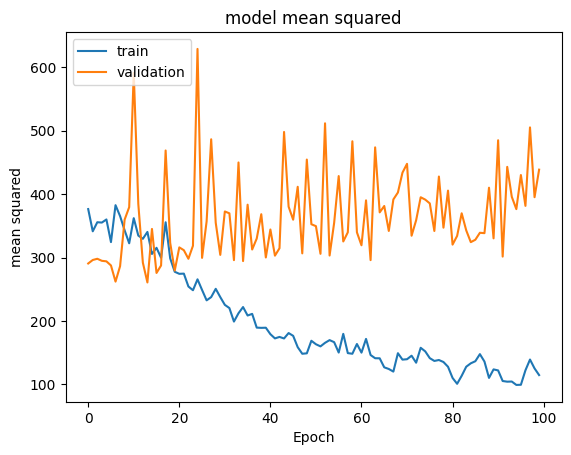

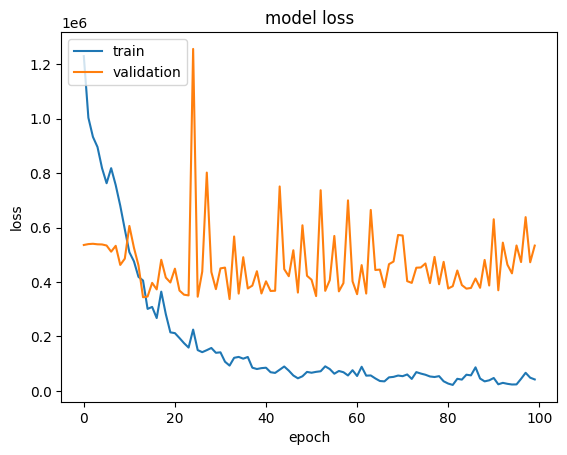

In [111]:
training_utils.history_metric_evaluation(history, display_epochs)

#### Multiple dense layers

In [112]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, stride=2)
outputs = basic_dense_block(covnet, [64])
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [113]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 240, 320, 3)]     0         
                                                                 
 batch_normalization_6 (Batc  (None, 240, 320, 3)      12        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 240, 320, 3)       0         
                                                                 
 separable_conv2d_6 (Separab  (None, 240, 320, 32)     123       
 leConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 240, 320, 32)     128       
 hNormalization)                                                 
                                                          

In [114]:
Wsave = model.get_weights()

In [115]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
36/36 [==============================] - 74s 2s/step - loss: 1215387.7500 - mae: 384.5610 - val_loss: 537702.3125 - val_mae: 293.6327
Epoch 2/100
36/36 [==============================] - 66s 2s/step - loss: 1038487.0000 - mae: 352.7765 - val_loss: 539564.9375 - val_mae: 296.7747
Epoch 3/100
36/36 [==============================] - 64s 2s/step - loss: 1001469.4375 - mae: 354.8700 - val_loss: 537052.6250 - val_mae: 292.5373
Epoch 4/100
36/36 [==============================] - 66s 2s/step - loss: 845261.3125 - mae: 316.3752 - val_loss: 525203.3125 - val_mae: 274.8762
Epoch 5/100
36/36 [==============================] - 67s 2s/step - loss: 773662.3750 - mae: 314.1994 - val_loss: 524377.1875 - val_mae: 273.8885
Epoch 6/100
36/36 [==============================] - 67s 2s/step - loss: 657410.6875 - mae: 326.2701 - val_loss: 521735.7188 - val_mae: 270.8923
Epoch 7/100
36/36 [==============================] - 68s 2s/step - loss: 676108.1250 - mae: 303.6618 - val_loss: 521506.6875 - 

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 73s 2s/step - loss: 395640.5625 - mae: 265.2705 - val_loss: 288639.1562 - val_mae: 231.0347
Epoch 16/100
36/36 [==============================] - 68s 2s/step - loss: 336365.0000 - mae: 265.4559 - val_loss: 308743.7500 - val_mae: 233.7568
Epoch 17/100
36/36 [==============================] - 65s 2s/step - loss: 312133.5938 - mae: 255.6296 - val_loss: 316326.4375 - val_mae: 260.7238
Epoch 18/100
36/36 [==============================] - ETA: 0s - loss: 226741.3750 - mae: 232.0395

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 71s 2s/step - loss: 226741.3750 - mae: 232.0395 - val_loss: 284520.0938 - val_mae: 244.2606
Epoch 19/100
36/36 [==============================] - 68s 2s/step - loss: 360828.0312 - mae: 235.8238 - val_loss: 316327.9688 - val_mae: 236.3535
Epoch 20/100
36/36 [==============================] - 82s 2s/step - loss: 200095.4062 - mae: 216.1678 - val_loss: 299167.6562 - val_mae: 241.6596
Epoch 21/100
36/36 [==============================] - 69s 2s/step - loss: 389607.6250 - mae: 240.4599 - val_loss: 287524.3125 - val_mae: 269.7783
Epoch 22/100
36/36 [==============================] - 65s 2s/step - loss: 263925.8438 - mae: 224.8475 - val_loss: 290589.2500 - val_mae: 259.7020
Epoch 23/100
36/36 [==============================] - 67s 2s/step - loss: 203590.5781 - mae: 212.9021 - val_loss: 372719.2812 - val_mae: 235.2968
Epoch 24/100
36/36 [==============================] - 68s 2s/step - loss: 244059.3594 - mae: 202.5510 - val_loss: 310358.1562 - val_mae: 

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 73s 2s/step - loss: 186445.8906 - mae: 162.3859 - val_loss: 281221.8750 - val_mae: 240.3981
Epoch 69/100
36/36 [==============================] - 67s 2s/step - loss: 160807.5781 - mae: 158.0981 - val_loss: 319682.1875 - val_mae: 271.6662
Epoch 70/100
36/36 [==============================] - 90s 2s/step - loss: 79859.8203 - mae: 144.8341 - val_loss: 327072.0938 - val_mae: 248.5662
Epoch 71/100
36/36 [==============================] - 74s 2s/step - loss: 133379.7188 - mae: 142.9401 - val_loss: 324505.8125 - val_mae: 222.8397
Epoch 72/100
36/36 [==============================] - 72s 2s/step - loss: 134501.7812 - mae: 148.3048 - val_loss: 299646.8125 - val_mae: 259.3863
Epoch 73/100
36/36 [==============================] - 72s 2s/step - loss: 209832.0312 - mae: 168.9518 - val_loss: 387873.4375 - val_mae: 319.4011
Epoch 74/100
36/36 [==============================] - 75s 2s/step - loss: 107083.7812 - mae: 147.4672 - val_loss: 351890.4375 - val_mae: 2

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


36/36 [==============================] - 78s 2s/step - loss: 127981.5078 - mae: 146.0759 - val_loss: 281133.5625 - val_mae: 227.5858
Epoch 78/100
36/36 [==============================] - 71s 2s/step - loss: 121805.0547 - mae: 149.4921 - val_loss: 342650.9375 - val_mae: 235.2491
Epoch 79/100
36/36 [==============================] - 72s 2s/step - loss: 83368.9844 - mae: 140.7246 - val_loss: 321235.1875 - val_mae: 225.2264
Epoch 80/100
36/36 [==============================] - 73s 2s/step - loss: 98149.8594 - mae: 135.8343 - val_loss: 311609.5312 - val_mae: 244.5909
Epoch 81/100
36/36 [==============================] - 74s 2s/step - loss: 162098.9219 - mae: 148.4955 - val_loss: 337776.8125 - val_mae: 224.2189
Epoch 82/100
36/36 [==============================] - 73s 2s/step - loss: 109363.6328 - mae: 143.4997 - val_loss: 313884.0625 - val_mae: 270.7622
Epoch 83/100
36/36 [==============================] - 71s 2s/step - loss: 167667.7812 - mae: 151.1555 - val_loss: 365253.2500 - val_mae: 29

In [116]:
global_history['depthwise_covnet_(32_64_128)_(64)'] = history

Min mae: 132.15626525878906
Min val_mae: 221.11822509765625
Min loss: 79859.8203125
Min val_loss: 281133.5625


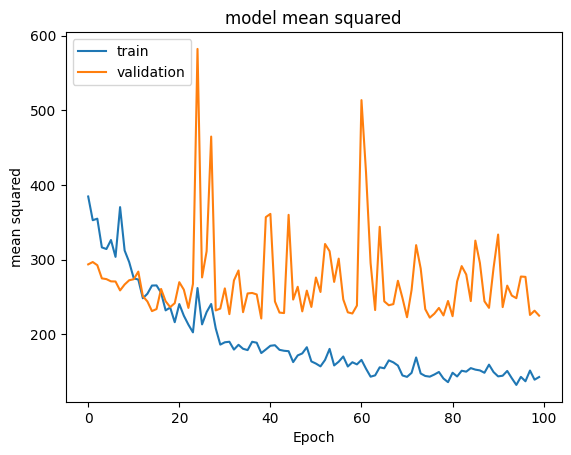

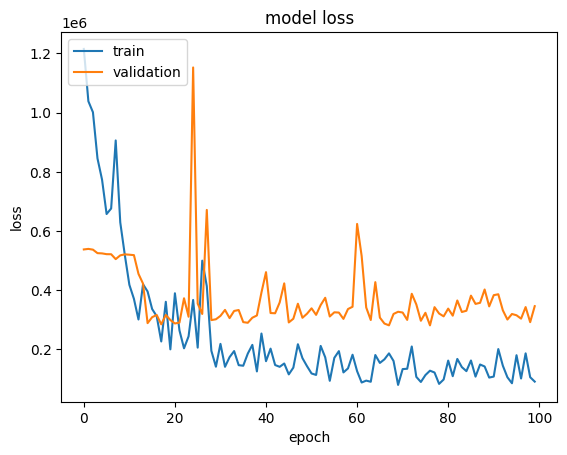

In [117]:
training_utils.history_metric_evaluation(history, display_epochs)


### Depthwise model with Max pooling

#### Single Output dense layer

In [127]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, pooling=True)
outputs = basic_dense_block(covnet, [])
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [128]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 240, 320, 3)]     0         
                                                                 
 batch_normalization_18 (Bat  (None, 240, 320, 3)      12        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 240, 320, 3)       0         
                                                                 
 separable_conv2d_18 (Separa  (None, 240, 320, 32)     123       
 bleConv2D)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 240, 320, 32)     128       
 chNormalization)                                                
                                                          

In [129]:
Wsave = model.get_weights()

In [140]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - 75s 261ms/step - loss: 1132103.1250 - mae: 397.2405 - val_loss: 552520.0625 - val_mae: 317.8192
Epoch 2/100
284/284 [==============================] - 62s 218ms/step - loss: 972597.8750 - mae: 371.0767 - val_loss: 1463664.3750 - val_mae: 782.8701
Epoch 3/100
284/284 [==============================] - 63s 221ms/step - loss: 562639.0625 - mae: 366.4535 - val_loss: 4934015.0000 - val_mae: 1666.3969
Epoch 4/100
284/284 [==============================] - 62s 218ms/step - loss: 428491.9062 - mae: 327.3602 - val_loss: 391205.6562 - val_mae: 358.8104
Epoch 5/100
284/284 [==============================] - 64s 224ms/step - loss: 356226.1562 - mae: 305.8820 - val_loss: 420944.5000 - val_mae: 411.9310
Epoch 6/100
284/284 [==============================] - 64s 223ms/step - loss: 370306.4688 - mae: 278.3935 - val_loss: 446813.7812 - val_mae: 306.8623
Epoch 7/100
284/284 [==============================] - 64s 223ms/step - loss: 173931.6562 - mae:

In [141]:
global_history['depthwise_covnet_pooling_(32_64_128)_()'] = history

Min mae: 75.38567352294922
Min val_mae: 306.8622741699219
Min loss: 15570.552734375
Min val_loss: 357396.6875


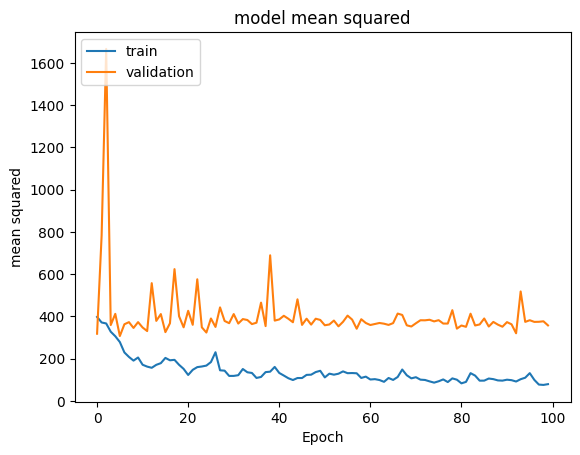

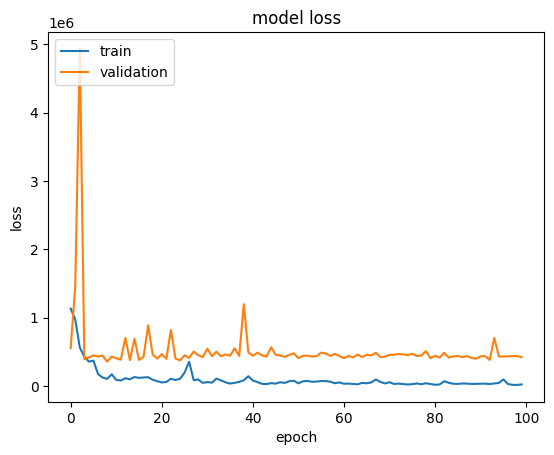

In [142]:
training_utils.history_metric_evaluation(history, display_epochs)

#### Multiple dense layers

Note: From this moment onwards the training was done with a batch size of 8 instead of 32/64/128.


In [22]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, pooling=True)
outputs = basic_dense_block(covnet, [32])
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 batch_normalization_6 (Bat  (None, 240, 320, 3)       12        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 240, 320, 3)       0         
                                                                 
 separable_conv2d_6 (Separa  (None, 240, 320, 32)      123       
 bleConv2D)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 240, 320, 32)      128       
 chNormalization)                                                
                                                           

In [24]:
Wsave = model.get_weights()

In [25]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - ETA: 0s - loss: 1928137.7500 - mae: 686.4469INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 368s 1s/step - loss: 1928137.7500 - mae: 686.4469 - val_loss: 517100.6250 - val_mae: 266.4576
Epoch 2/100
284/284 [==============================] - ETA: 0s - loss: 1405552.6250 - mae: 552.0344INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 291s 1s/step - loss: 1405552.6250 - mae: 552.0344 - val_loss: 433281.0625 - val_mae: 407.0336
Epoch 3/100
284/284 [==============================] - 274s 956ms/step - loss: 1424017.3750 - mae: 540.1878 - val_loss: 1348071.8750 - val_mae: 730.4498
Epoch 4/100
284/284 [==============================] - 269s 941ms/step - loss: 1457087.5000 - mae: 607.2017 - val_loss: 4012894.5000 - val_mae: 1567.6760
Epoch 5/100
284/284 [==============================] - 268s 940ms/step - loss: 3335333.2500 - mae: 1083.6873 - val_loss: 1971518.6250 - val_mae: 1040.1085
Epoch 6/100
284/284 [==============================] - 260s 911ms/step - loss: 11205139.0000 - mae: 1964.3221 - val_loss: 895969.0000 - val_mae: 673.6266
Epoch 7/100
284/284 [==============================] - 260s 913ms/step - loss: 4263680.5000 - mae: 1329.8630 - val_loss: 2953481.0000 - val_mae: 1432.6622
Epoch 8/100
284/284 [==============================] - 261s 915ms/step - loss: 4367531.0000 

INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 311s 1s/step - loss: 1707084.6250 - mae: 711.5117 - val_loss: 432088.3438 - val_mae: 411.3470
Epoch 47/100
284/284 [==============================] - ETA: 0s - loss: 1619934.0000 - mae: 691.0343INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 311s 1s/step - loss: 1619934.0000 - mae: 691.0343 - val_loss: 384808.4062 - val_mae: 272.1022
Epoch 48/100
284/284 [==============================] - ETA: 0s - loss: 1648110.2500 - mae: 684.2033INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 317s 1s/step - loss: 1648110.2500 - mae: 684.2033 - val_loss: 357883.0312 - val_mae: 331.2251
Epoch 49/100
284/284 [==============================] - ETA: 0s - loss: 1512028.0000 - mae: 651.9423INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 335s 1s/step - loss: 1512028.0000 - mae: 651.9423 - val_loss: 354498.2500 - val_mae: 265.0427
Epoch 50/100
284/284 [==============================] - ETA: 0s - loss: 1413295.1250 - mae: 619.1587INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 357s 1s/step - loss: 1413295.1250 - mae: 619.1587 - val_loss: 339886.4375 - val_mae: 299.5839
Epoch 51/100
284/284 [==============================] - ETA: 0s - loss: 1525070.2500 - mae: 681.7520INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 305s 1s/step - loss: 1525070.2500 - mae: 681.7520 - val_loss: 326605.2500 - val_mae: 287.5187
Epoch 52/100
284/284 [==============================] - 265s 923ms/step - loss: 1363124.5000 - mae: 585.6313 - val_loss: 746342.9375 - val_mae: 637.5493
Epoch 53/100
284/284 [==============================] - 531s 2s/step - loss: 1483261.3750 - mae: 659.3212 - val_loss: 622714.8125 - val_mae: 561.9318
Epoch 54/100
284/284 [==============================] - 557s 2s/step - loss: 1797932.6250 - mae: 794.4174 - val_loss: 488968.0938 - val_mae: 415.1839
Epoch 55/100
284/284 [==============================] - 592s 2s/step - loss: 1729670.8750 - mae: 791.0405 - val_loss: 389510.4688 - val_mae: 344.0116
Epoch 56/100
284/284 [==============================] - 616s 2s/step - loss: 2278812.0000 - mae: 868.9778 - val_loss: 641041.0000 - val_mae: 463.5174
Epoch 57/100
284/284 [==============================] - 598s 2s/step - loss: 2655979.5000 - mae: 1014.0300 - v

INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 635s 2s/step - loss: 1552097.7500 - mae: 666.9763 - val_loss: 319193.2812 - val_mae: 264.4856
Epoch 61/100
284/284 [==============================] - 607s 2s/step - loss: 1502244.6250 - mae: 693.1898 - val_loss: 4225768.0000 - val_mae: 1516.2740
Epoch 62/100
284/284 [==============================] - 629s 2s/step - loss: 2203395.0000 - mae: 958.4514 - val_loss: 2567227.7500 - val_mae: 1430.4172
Epoch 63/100
284/284 [==============================] - 313s 1s/step - loss: 2834973.2500 - mae: 1095.0232 - val_loss: 730952.3125 - val_mae: 655.2706
Epoch 64/100
284/284 [==============================] - 259s 907ms/step - loss: 3213476.5000 - mae: 1188.8457 - val_loss: 1011935.5000 - val_mae: 770.5030
Epoch 65/100
284/284 [==============================] - ETA: 0s - loss: 10658094.0000 - mae: 1823.5813INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


INFO:tensorflow:Assets written to: VGG16_(256).tf/assets


284/284 [==============================] - 273s 957ms/step - loss: 10658094.0000 - mae: 1823.5813 - val_loss: 255352.8438 - val_mae: 271.1187
Epoch 66/100
284/284 [==============================] - 541s 2s/step - loss: 4134247.2500 - mae: 1161.5959 - val_loss: 1085991.8750 - val_mae: 747.0033
Epoch 67/100
284/284 [==============================] - 458s 2s/step - loss: 5340592.5000 - mae: 1552.9047 - val_loss: 1518194.7500 - val_mae: 1052.6168
Epoch 68/100
284/284 [==============================] - 297s 1s/step - loss: 6601117.5000 - mae: 1781.8624 - val_loss: 435392.9688 - val_mae: 500.7164
Epoch 69/100
284/284 [==============================] - 278s 970ms/step - loss: 8078251.5000 - mae: 1765.2910 - val_loss: 2895425.7500 - val_mae: 1447.3336
Epoch 70/100
284/284 [==============================] - 1056s 4s/step - loss: 6105057.0000 - mae: 1738.0729 - val_loss: 652663.0625 - val_mae: 606.9380
Epoch 71/100
284/284 [==============================] - 1595s 6s/step - loss: 8097293.5000 - m

In [26]:
global_history['depthwise_covnet_pooling_(32_64_128)_(64)'] = history

Min mae: 540.1878051757812
Min val_mae: 264.485595703125
Min loss: 1363124.5
Min val_loss: 255352.84375


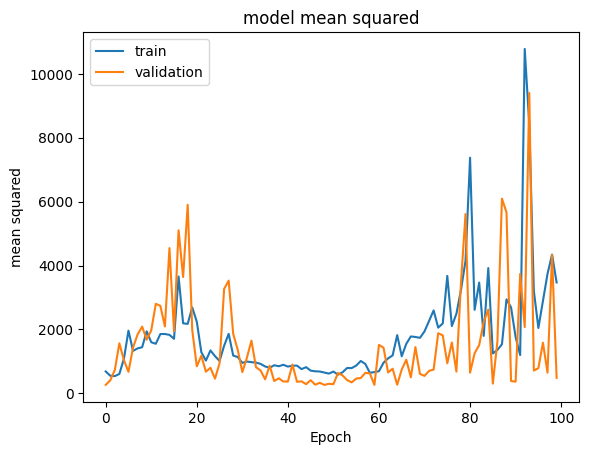

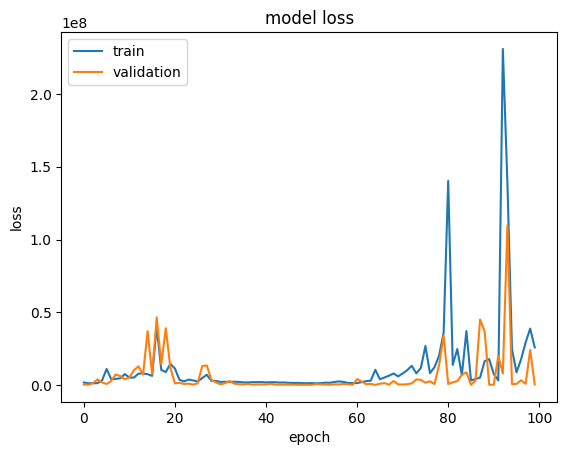

In [35]:
training_utils.history_metric_evaluation(global_history['depthwise_covnet_pooling_(32_64_128)_(64)'], display_epochs)

#### Multiple dense layers with dropout

In [18]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, pooling=True, dropout=True)
outputs = basic_dense_block(covnet, [32])
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 240, 320, 3)      12        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 240, 320, 3)       0         
                                                                 
 separable_conv2d (Separable  (None, 240, 320, 32)     123       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 240, 320, 32)     128       
 hNormalization)                                                 
                                                             

In [20]:
Wsave = model.get_weights()

In [21]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - ETA: 0s - loss: 1363694.8750 - mae: 407.0801

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 1660s 6s/step - loss: 1363694.8750 - mae: 407.0801 - val_loss: 628478.1875 - val_mae: 420.8065
Epoch 2/100
284/284 [==============================] - 1574s 6s/step - loss: 1334677.6250 - mae: 382.4380 - val_loss: 3377293.0000 - val_mae: 1728.7780
Epoch 3/100
284/284 [==============================] - ETA: 0s - loss: 1341420.3750 - mae: 387.6766

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 1566s 6s/step - loss: 1341420.3750 - mae: 387.6766 - val_loss: 538537.1875 - val_mae: 295.7517
Epoch 4/100
284/284 [==============================] - ETA: 0s - loss: 1416129.7500 - mae: 381.5310

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 1566s 6s/step - loss: 1416129.7500 - mae: 381.5310 - val_loss: 489305.9688 - val_mae: 458.3310
Epoch 5/100
284/284 [==============================] - 1550s 5s/step - loss: 1366213.1250 - mae: 400.2811 - val_loss: 510351.1562 - val_mae: 264.8224
Epoch 6/100
284/284 [==============================] - 1544s 5s/step - loss: 1270014.2500 - mae: 363.5260 - val_loss: 524305.9375 - val_mae: 305.5278
Epoch 7/100
284/284 [==============================] - 1553s 5s/step - loss: 1165949.3750 - mae: 360.1432 - val_loss: 929357.9375 - val_mae: 773.0015
Epoch 8/100
284/284 [==============================] - 1551s 5s/step - loss: 1057065.6250 - mae: 347.6126 - val_loss: 686750.8750 - val_mae: 618.2420
Epoch 9/100
284/284 [==============================] - 1544s 5s/step - loss: 1107552.1250 - mae: 372.5092 - val_loss: 970986.3125 - val_mae: 780.1015
Epoch 10/100
284/284 [==============================] - 1546s 5s/step - loss: 1412436.0000 - mae: 370.4054 - val

KeyboardInterrupt: 

In [ ]:
global_history['depthwise_covnet_pooling_(32_64_128)_(64)_dropout'] = history

In [ ]:
training_utils.history_metric_evaluation(history, display_epochs)

### Depthwise model with residual connections

In [16]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, stride=2, residual=True)
outputs = basic_dense_block(covnet, [64])
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 320, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 240, 320, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

In [18]:
Wsave = model.get_weights()

In [19]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - ETA: 0s - loss: 1187618.1250 - mae: 362.3366

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 87s 278ms/step - loss: 1187618.1250 - mae: 362.3366 - val_loss: 514114.5000 - val_mae: 264.0665
Epoch 2/100
284/284 [==============================] - ETA: 0s - loss: 1095969.2500 - mae: 359.9320

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 56s 197ms/step - loss: 1095969.2500 - mae: 359.9320 - val_loss: 344368.6250 - val_mae: 320.7711
Epoch 3/100
284/284 [==============================] - 54s 190ms/step - loss: 1095034.3750 - mae: 359.2112 - val_loss: 403532.6250 - val_mae: 476.3550
Epoch 4/100
284/284 [==============================] - 53s 187ms/step - loss: 1066233.3750 - mae: 367.6152 - val_loss: 8795958.0000 - val_mae: 2357.3987
Epoch 5/100
284/284 [==============================] - ETA: 0s - loss: 972715.0625 - mae: 347.7686

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 73s 258ms/step - loss: 972715.0625 - mae: 347.7686 - val_loss: 311811.8750 - val_mae: 222.5568
Epoch 6/100
284/284 [==============================] - 55s 193ms/step - loss: 885427.3125 - mae: 320.6825 - val_loss: 346017.1562 - val_mae: 319.9019
Epoch 7/100
284/284 [==============================] - 52s 184ms/step - loss: 792105.5625 - mae: 322.8024 - val_loss: 1277974.5000 - val_mae: 470.9288
Epoch 8/100
284/284 [==============================] - 52s 184ms/step - loss: 816584.8125 - mae: 316.4359 - val_loss: 409671.0312 - val_mae: 252.1275
Epoch 9/100
284/284 [==============================] - 52s 183ms/step - loss: 759063.6875 - mae: 321.9946 - val_loss: 327864.4062 - val_mae: 220.3344
Epoch 10/100
284/284 [==============================] - 52s 183ms/step - loss: 625686.0000 - mae: 301.1324 - val_loss: 329021.6875 - val_mae: 258.9557
Epoch 11/100
284/284 [==============================] - 55s 192ms/step - loss: 480434.1875 - mae: 277.9810 - v

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 58s 204ms/step - loss: 399388.8750 - mae: 253.8613 - val_loss: 264999.4688 - val_mae: 225.8459
Epoch 24/100
284/284 [==============================] - 53s 185ms/step - loss: 450767.0625 - mae: 271.5831 - val_loss: 419341.0938 - val_mae: 284.1672
Epoch 25/100
284/284 [==============================] - 52s 181ms/step - loss: 198723.0625 - mae: 219.5169 - val_loss: 425866.3750 - val_mae: 327.1547
Epoch 26/100
284/284 [==============================] - 53s 184ms/step - loss: 284686.1250 - mae: 227.9655 - val_loss: 400841.3438 - val_mae: 230.1258
Epoch 27/100
284/284 [==============================] - 53s 186ms/step - loss: 380941.9375 - mae: 250.4425 - val_loss: 373798.3750 - val_mae: 276.7044
Epoch 28/100
284/284 [==============================] - 53s 184ms/step - loss: 652876.8750 - mae: 248.0041 - val_loss: 515635.1250 - val_mae: 501.6195
Epoch 29/100
284/284 [==============================] - 52s 182ms/step - loss: 519973.2812 - mae: 265.9662 

In [20]:
global_history['depthwise_covnet_residual_(32_64_128)_(64)'] = history

Min mae: 134.9348602294922
Min val_mae: 207.6202850341797
Min loss: 87384.359375
Min val_loss: 264999.46875


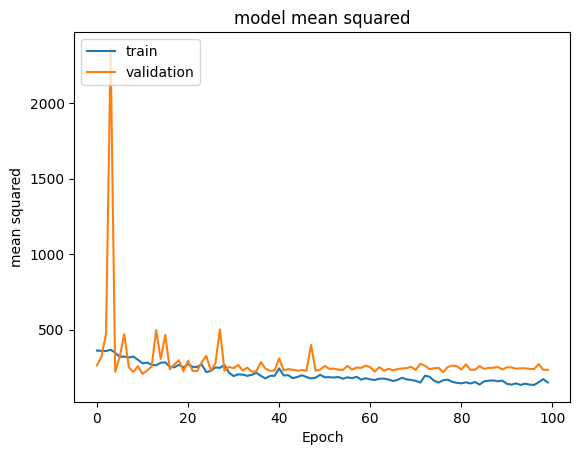

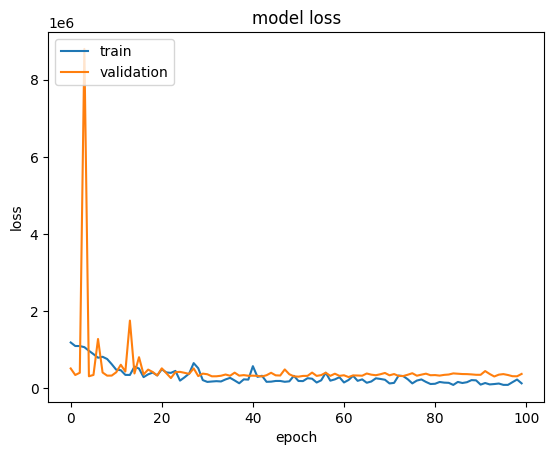

In [21]:
training_utils.history_metric_evaluation(history, display_epochs)

In [22]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, stride=2, residual=True, dropout=True)
outputs = basic_dense_block(covnet, [])
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 240, 320, 3)  12         ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 240, 320, 3)  0           ['batch_normalization_6[0][0]']  
                                                                                            

In [24]:
Wsave = model.get_weights()

In [25]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - 52s 177ms/step - loss: 1144450.8750 - mae: 370.4424 - val_loss: 534538.6875 - val_mae: 288.7073
Epoch 2/100
284/284 [==============================] - 50s 176ms/step - loss: 1086860.5000 - mae: 373.3461 - val_loss: 296768.8750 - val_mae: 269.9444
Epoch 3/100
284/284 [==============================] - 50s 177ms/step - loss: 1050529.6250 - mae: 373.5095 - val_loss: 430348.4688 - val_mae: 298.3915
Epoch 4/100
284/284 [==============================] - 51s 177ms/step - loss: 1020866.3750 - mae: 382.5457 - val_loss: 353017.1875 - val_mae: 295.9603
Epoch 5/100
284/284 [==============================] - 51s 178ms/step - loss: 947224.5625 - mae: 373.7769 - val_loss: 392441.1875 - val_mae: 320.8653
Epoch 6/100
284/284 [==============================] - 51s 178ms/step - loss: 952770.2500 - mae: 386.6366 - val_loss: 342405.4062 - val_mae: 267.2253
Epoch 7/100
284/284 [==============================] - 51s 177ms/step - loss: 823654.5625 - mae:

In [26]:
global_history['depthwise_covnet_residual_(32_64_128)_()_dropout'] = history

Min mae: 189.66159057617188
Min val_mae: 267.225341796875
Min loss: 70939.8671875
Min val_loss: 296768.875


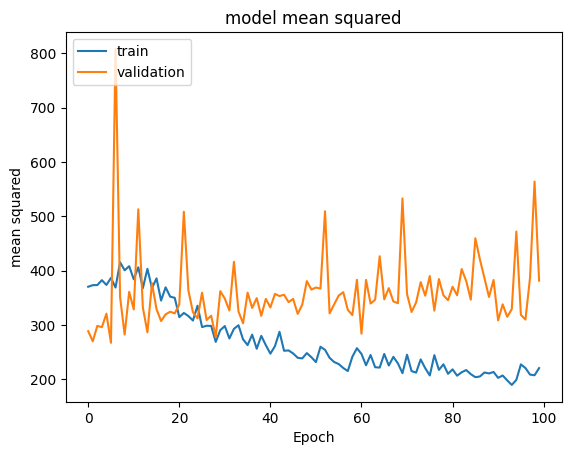

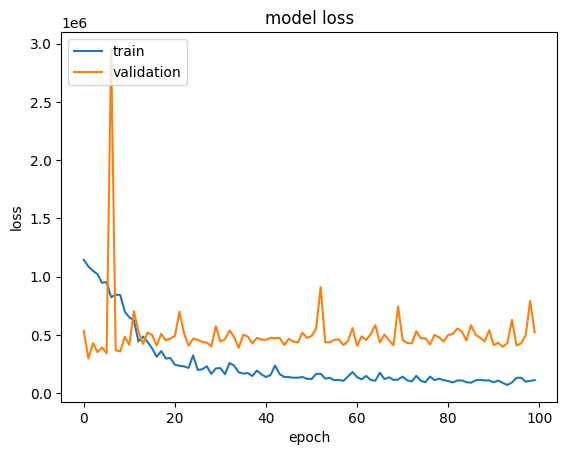

In [27]:
training_utils.history_metric_evaluation(history, display_epochs)

### Depthwise model with residual connections and global pooling

In [28]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, stride=2, pooling=True, residual=True)
outputs = basic_dense_block(covnet, [64], global_pooling=True)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 240, 320, 3)  12         ['input_1[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 240, 320, 3)  0           ['batch_normalization_12[0][0]'] 
                                                                                            

In [30]:
Wsave = model.get_weights()

In [31]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - 52s 178ms/step - loss: 1245544.6250 - mae: 346.1263 - val_loss: 510644.3438 - val_mae: 263.6502
Epoch 2/100
284/284 [==============================] - ETA: 0s - loss: 1109385.7500 - mae: 371.7917

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 54s 190ms/step - loss: 1109385.7500 - mae: 371.7917 - val_loss: 244790.8125 - val_mae: 239.2894
Epoch 3/100
284/284 [==============================] - 52s 181ms/step - loss: 1082371.5000 - mae: 368.1370 - val_loss: 340125.6562 - val_mae: 219.4945
Epoch 4/100
284/284 [==============================] - 52s 181ms/step - loss: 1086620.5000 - mae: 342.1888 - val_loss: 486964.8750 - val_mae: 421.1289
Epoch 5/100
284/284 [==============================] - ETA: 0s - loss: 1083690.1250 - mae: 360.2161

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 55s 193ms/step - loss: 1083690.1250 - mae: 360.2161 - val_loss: 226606.4844 - val_mae: 206.5216
Epoch 6/100
284/284 [==============================] - ETA: 0s - loss: 1009829.0625 - mae: 354.6501

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 55s 193ms/step - loss: 1009829.0625 - mae: 354.6501 - val_loss: 193893.9531 - val_mae: 207.2551
Epoch 7/100
284/284 [==============================] - 52s 181ms/step - loss: 981628.8750 - mae: 347.2730 - val_loss: 499557.3750 - val_mae: 315.4490
Epoch 8/100
284/284 [==============================] - 52s 182ms/step - loss: 1063971.0000 - mae: 341.5918 - val_loss: 3077235.7500 - val_mae: 1138.9908
Epoch 9/100
284/284 [==============================] - 52s 182ms/step - loss: 991205.1875 - mae: 340.0873 - val_loss: 440775.0312 - val_mae: 368.0379
Epoch 10/100
284/284 [==============================] - ETA: 0s - loss: 975252.9375 - mae: 324.4944

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 55s 195ms/step - loss: 975252.9375 - mae: 324.4944 - val_loss: 176712.7031 - val_mae: 178.9696
Epoch 11/100
284/284 [==============================] - 52s 183ms/step - loss: 956813.7500 - mae: 316.0629 - val_loss: 7218890.0000 - val_mae: 1582.2664
Epoch 12/100
284/284 [==============================] - 51s 181ms/step - loss: 953902.0000 - mae: 328.4355 - val_loss: 318791.0938 - val_mae: 299.4554
Epoch 13/100
284/284 [==============================] - 51s 180ms/step - loss: 996911.1250 - mae: 319.0096 - val_loss: 179044.8906 - val_mae: 192.2435
Epoch 14/100
284/284 [==============================] - 51s 180ms/step - loss: 900625.8125 - mae: 307.0089 - val_loss: 194986.2188 - val_mae: 190.2051
Epoch 15/100
284/284 [==============================] - 51s 181ms/step - loss: 881188.0000 - mae: 314.1913 - val_loss: 179301.8438 - val_mae: 199.8310
Epoch 16/100
284/284 [==============================] - 51s 179ms/step - loss: 820219.1250 - mae: 299.002

In [32]:
global_history['depthwise_covnet_residual_pooling_(32_64_128)_(64)'] = history

Min mae: 227.7332305908203
Min val_mae: 169.3444366455078
Min loss: 248853.9375
Min val_loss: 176712.703125


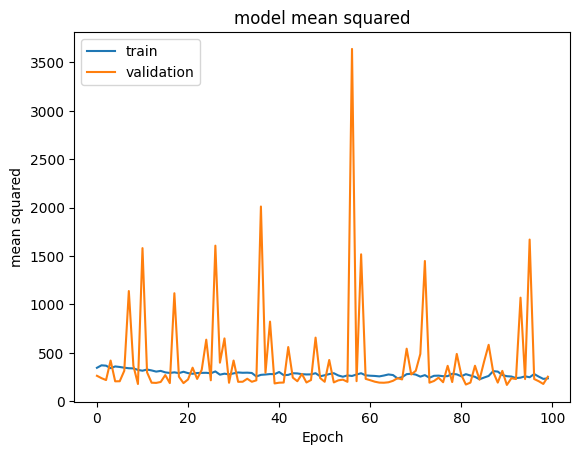

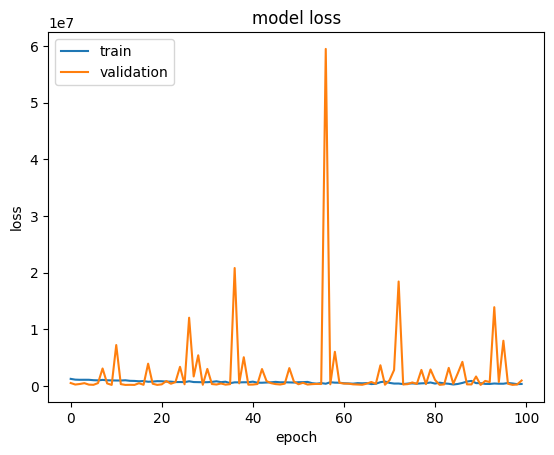

In [33]:
training_utils.history_metric_evaluation(history, display_epochs)

In [34]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, stride=2, pooling=True, residual=True, dropout=True)
outputs = basic_dense_block(covnet, [64], global_pooling=True)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [35]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 240, 320, 3)  12         ['input_1[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activation_18 (Activation)     (None, 240, 320, 3)  0           ['batch_normalization_18[0][0]'] 
                                                                                            

In [36]:
Wsave = model.get_weights()

In [37]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - 53s 181ms/step - loss: 1240406.7500 - mae: 357.5602 - val_loss: 516338.4375 - val_mae: 267.2471
Epoch 2/100
284/284 [==============================] - 51s 179ms/step - loss: 1104252.2500 - mae: 362.2900 - val_loss: 390222.1875 - val_mae: 233.3448
Epoch 3/100
284/284 [==============================] - 51s 177ms/step - loss: 1104224.3750 - mae: 368.1455 - val_loss: 261721.9688 - val_mae: 253.6624
Epoch 4/100
284/284 [==============================] - 51s 178ms/step - loss: 1070552.7500 - mae: 363.0072 - val_loss: 375660.3750 - val_mae: 241.5694
Epoch 5/100
284/284 [==============================] - 51s 178ms/step - loss: 1042509.5000 - mae: 354.4482 - val_loss: 232332.0625 - val_mae: 230.7105
Epoch 6/100
284/284 [==============================] - 51s 179ms/step - loss: 1051810.0000 - mae: 363.4489 - val_loss: 309095.0312 - val_mae: 236.8028
Epoch 7/100
284/284 [==============================] - 51s 179ms/step - loss: 1102627.1250 - m

In [38]:
global_history['depthwise_covnet_residual_pooling_(32_64_128)_(64)_dropout'] = history

Min mae: 265.4681701660156
Min val_mae: 192.3275146484375
Min loss: 424616.65625
Min val_loss: 210988.3125


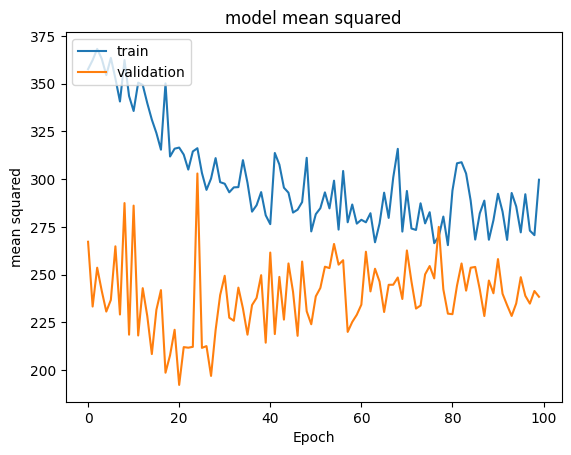

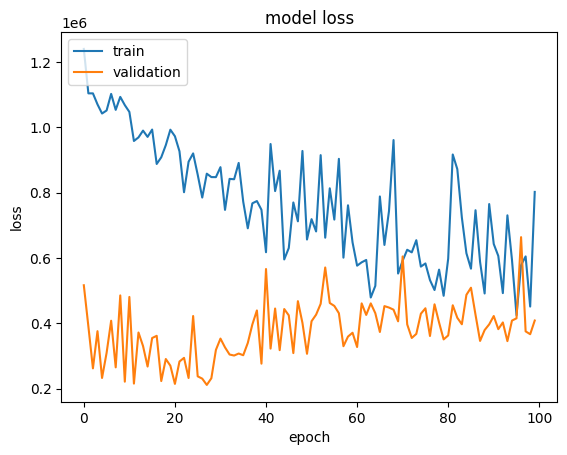

In [39]:
training_utils.history_metric_evaluation(history, display_epochs)

## Xception


In [16]:
def Xception_model():
    covnet = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)
    covnet = custom_depthwise_conv_block(covnet, [32, 64], 2, stride=2, pooling=True, residual=True)
    covnet = custom_depthwise_conv_block(covnet, [128], 2, residual=True)
    outputs = basic_dense_block(covnet, [], global_pooling=True)
    return keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model = Xception_model()
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 236, 316, 32  2400        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 236, 316, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
Wsave = model.get_weights()

In [20]:
model.set_weights(Wsave)
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    )

Epoch 1/100
284/284 [==============================] - ETA: 0s - loss: 1158889.2500 - mae: 347.6202

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 95s 277ms/step - loss: 1158889.2500 - mae: 347.6202 - val_loss: 509535.1562 - val_mae: 262.0895
Epoch 2/100
284/284 [==============================] - ETA: 0s - loss: 1090828.0000 - mae: 384.1928

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 60s 210ms/step - loss: 1090828.0000 - mae: 384.1928 - val_loss: 395153.6250 - val_mae: 235.5596
Epoch 3/100
284/284 [==============================] - ETA: 0s - loss: 1039406.7500 - mae: 372.5119

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 63s 220ms/step - loss: 1039406.7500 - mae: 372.5119 - val_loss: 321811.0625 - val_mae: 224.7215
Epoch 4/100
284/284 [==============================] - 53s 185ms/step - loss: 987319.4375 - mae: 347.2560 - val_loss: 477100.5000 - val_mae: 278.9394
Epoch 5/100
284/284 [==============================] - ETA: 0s - loss: 1016656.6875 - mae: 377.1215

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 56s 196ms/step - loss: 1016656.6875 - mae: 377.1215 - val_loss: 205453.8750 - val_mae: 259.2722
Epoch 6/100
284/284 [==============================] - 56s 195ms/step - loss: 972662.0000 - mae: 373.7020 - val_loss: 480065.4062 - val_mae: 371.2026
Epoch 7/100
284/284 [==============================] - 58s 203ms/step - loss: 959944.3125 - mae: 355.9286 - val_loss: 318671.4375 - val_mae: 310.3809
Epoch 8/100
284/284 [==============================] - 59s 208ms/step - loss: 985232.2500 - mae: 375.5429 - val_loss: 284048.7812 - val_mae: 232.0642
Epoch 9/100
284/284 [==============================] - 67s 236ms/step - loss: 948199.8750 - mae: 369.5307 - val_loss: 1127359.6250 - val_mae: 652.3936
Epoch 10/100
284/284 [==============================] - 58s 206ms/step - loss: 933002.6250 - mae: 369.8260 - val_loss: 219451.4219 - val_mae: 218.6866
Epoch 11/100
284/284 [==============================] - 53s 186ms/step - loss: 898854.3750 - mae: 356.7419 - 

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 56s 197ms/step - loss: 919220.2500 - mae: 370.4380 - val_loss: 191100.3750 - val_mae: 235.3903
Epoch 13/100
284/284 [==============================] - 53s 184ms/step - loss: 892867.4375 - mae: 377.3478 - val_loss: 226193.3750 - val_mae: 233.1286
Epoch 14/100
284/284 [==============================] - 54s 188ms/step - loss: 883332.3125 - mae: 362.7451 - val_loss: 227313.2188 - val_mae: 242.2280
Epoch 15/100
284/284 [==============================] - 55s 192ms/step - loss: 852809.3125 - mae: 351.6279 - val_loss: 7962093.0000 - val_mae: 1644.6333
Epoch 16/100
284/284 [==============================] - 53s 185ms/step - loss: 821380.1250 - mae: 371.7161 - val_loss: 326328.3125 - val_mae: 330.1847
Epoch 17/100
284/284 [==============================] - 52s 183ms/step - loss: 877775.1875 - mae: 345.2585 - val_loss: 4694265.0000 - val_mae: 1372.1171
Epoch 18/100
284/284 [==============================] - 52s 184ms/step - loss: 818610.8125 - mae: 355.6

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 56s 197ms/step - loss: 819910.1250 - mae: 356.1723 - val_loss: 167526.7812 - val_mae: 195.1044
Epoch 20/100
284/284 [==============================] - 53s 187ms/step - loss: 734499.2500 - mae: 321.2772 - val_loss: 46260452.0000 - val_mae: 4639.3696
Epoch 21/100
284/284 [==============================] - 54s 188ms/step - loss: 804211.1250 - mae: 360.2248 - val_loss: 260612.0781 - val_mae: 271.9582
Epoch 22/100
284/284 [==============================] - 53s 186ms/step - loss: 773481.0625 - mae: 332.3691 - val_loss: 249335.7969 - val_mae: 244.7224
Epoch 23/100
284/284 [==============================] - 52s 183ms/step - loss: 768857.6250 - mae: 342.6090 - val_loss: 474774.2188 - val_mae: 348.0940
Epoch 24/100
284/284 [==============================] - 52s 184ms/step - loss: 785656.3125 - mae: 335.3553 - val_loss: 195729.7188 - val_mae: 218.6656
Epoch 25/100
284/284 [==============================] - 51s 180ms/step - loss: 784652.5625 - mae: 331.25

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 55s 192ms/step - loss: 438727.8438 - mae: 268.8408 - val_loss: 163790.8281 - val_mae: 198.9861
Epoch 50/100
284/284 [==============================] - ETA: 0s - loss: 539243.6875 - mae: 283.6711

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 54s 190ms/step - loss: 539243.6875 - mae: 283.6711 - val_loss: 161983.9688 - val_mae: 237.9692
Epoch 51/100
284/284 [==============================] - ETA: 0s - loss: 614310.8125 - mae: 294.5890

INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


INFO:tensorflow:Assets written to: VGG16_(256).tf\assets


284/284 [==============================] - 55s 194ms/step - loss: 614310.8125 - mae: 294.5890 - val_loss: 149223.5938 - val_mae: 179.6430
Epoch 52/100
284/284 [==============================] - 51s 180ms/step - loss: 535041.2500 - mae: 279.8532 - val_loss: 208153.2188 - val_mae: 194.2339
Epoch 53/100
284/284 [==============================] - 51s 181ms/step - loss: 520285.6875 - mae: 286.1028 - val_loss: 168255.0312 - val_mae: 214.1231
Epoch 54/100
284/284 [==============================] - 52s 181ms/step - loss: 408157.2500 - mae: 266.4029 - val_loss: 383231.1250 - val_mae: 326.4587
Epoch 55/100
284/284 [==============================] - 51s 181ms/step - loss: 529950.6875 - mae: 272.0312 - val_loss: 161070.9531 - val_mae: 173.8696
Epoch 56/100
284/284 [==============================] - 52s 182ms/step - loss: 448399.7188 - mae: 272.5115 - val_loss: 268970.0312 - val_mae: 201.7484
Epoch 57/100
284/284 [==============================] - 52s 181ms/step - loss: 498307.6562 - mae: 266.4139 

In [21]:
global_history['Xception'] = history

Min mae: 225.2051239013672
Min val_mae: 168.3600616455078
Min loss: 245828.953125
Min val_loss: 149223.59375


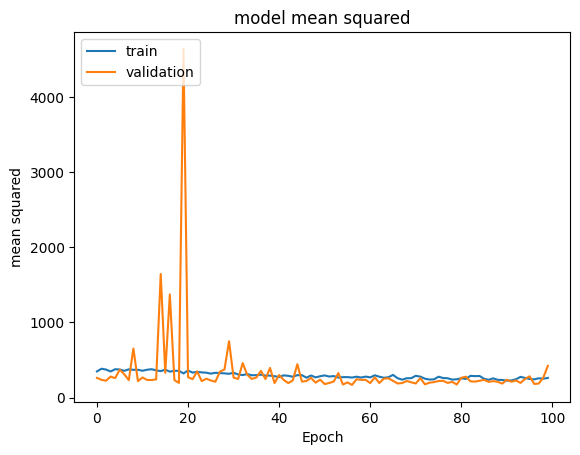

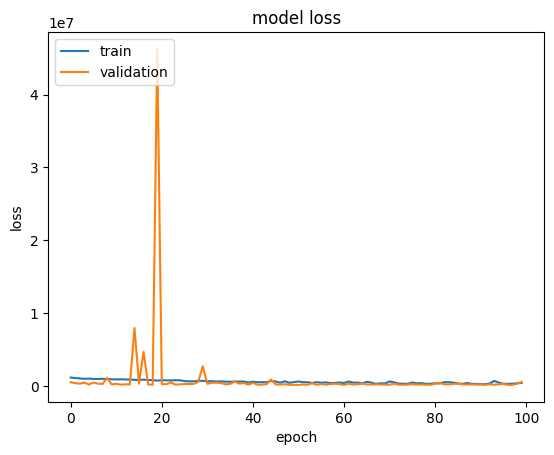

In [22]:
training_utils.history_metric_evaluation(history, display_epochs)

In [23]:
model.evaluate(test_generator)

200/200 [==============================] - 41s 203ms/step - loss: 561582.5000 - mae: 447.6366


[561582.5, 447.6366271972656]

In [24]:
model.save('Xception.tf')

INFO:tensorflow:Assets written to: Xception.tf\assets


INFO:tensorflow:Assets written to: Xception.tf\assets


## VGG16

In [25]:
def base_vgg_16_layers(input):
    input = keras.applications.vgg16.preprocess_input(input)
    covnet = keras.applications.vgg16.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=img_size + (img_channels,))(input)
    covnet.trainable = False
    return keras.Model(inputs=input, outputs=covnet)


def output_vgg_16_layers(covnet, node_size):
    output = basic_dense_block(covnet, node_size)
    return keras.Model(inputs=covnet, outputs=output)


def vgg_16_model():
    input = keras.applications.vgg16.preprocess_input(inputs)
    covnet = base_vgg_16_layers()(input)
    return output_vgg_16_layers(covnet, input)


def activate_fine_tuning_on_vgg_16(ft_model):
    # Flag to indicate whether the layers should be trainable
    set_trainable = False

    # Assuming 'vgg16' is the name of the nested VGG16 model
    vgg16 = ft_model.get_layer('vgg16')
    vgg16.trainable = True

    for layer in vgg16.layers:
        # Start fine-tuning from 'block5_conv1'
        if layer.name == 'block5_conv1':
            set_trainable = True

        # Set the trainable flag for the layers
        if set_trainable:
            print(f'Unfreezing layer {layer.name}')
            layer.trainable = True
        else:
            print(f'Freezing layer {layer.name}')
            layer.trainable = False


In [26]:
conv_base = base_vgg_16_layers(keras.layers.Input(shape=img_size + (img_channels,)))
conv_base.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 10, 512)        14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [27]:
feature_train = conv_base.predict(train_generator, batch_size=32, verbose=1)
feature_val = conv_base.predict(val_generator, batch_size=32, verbose=1)


63/63 [==============================] - 9s 147ms/step


In [28]:
print(feature_train.shape)
display(feature_train[0][0])
display(train_df.head())

(2272, 7, 10, 512)


array([[0.83527994, 0.        , 0.        , ..., 0.        , 1.242805  ,
        0.        ],
       [0.46118003, 0.        , 0.12803346, ..., 0.        , 1.2657197 ,
        0.        ],
       [0.7241957 , 0.        , 0.        , ..., 0.        , 1.2067479 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.06489927, ..., 0.        , 0.81673634,
        0.        ],
       [0.41732717, 0.        , 0.        , ..., 0.        , 0.79507375,
        0.        ],
       [0.57950115, 0.        , 0.01117742, ..., 0.        , 0.85821885,
        0.        ]], dtype=float32)

,0,1,2,3,4
0,0001.jpg,161.0,water park,0,0
1,0008.jpg,855.0,marathon,0,0
2,0010.jpg,455.0,protest,0,0
3,0012.jpg,7139.0,stadium,0,0
4,0014.jpg,111.0,protest,0,0


In [29]:
i_model = output_vgg_16_layers(keras.Input(shape=feature_train.shape[1:]), [])

i_model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [30]:
dense_history = i_model.fit(feature_train, train_df[1].values,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            validation_data=(feature_val, val_df[1].values),
                            )

Epoch 1/100
71/71 [==============================] - 1s 8ms/step - loss: 1342373.7500 - mae: 336.0610 - val_loss: 456209.6875 - val_mae: 290.1085
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 1288018.3750 - mae: 369.0854 - val_loss: 449905.1250 - val_mae: 338.2942
Epoch 3/100
71/71 [==============================] - 0s 6ms/step - loss: 1277706.8750 - mae: 401.2095 - val_loss: 451783.8750 - val_mae: 357.8001
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 1274914.1250 - mae: 409.1419 - val_loss: 453584.5938 - val_mae: 368.3663
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 1273522.2500 - mae: 421.3080 - val_loss: 453754.6875 - val_mae: 368.9456
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 1270741.2500 - mae: 416.2479 - val_loss: 453643.9688 - val_mae: 368.1174
Epoch 7/100
71/71 [==============================] - 0s 5ms/step - loss: 1270012.7500 - mae: 413.6193 - val_loss: 454355.718

In [31]:
global_history['vgg16_()_dense'] = dense_history

Min mae: 336.06103515625
Min val_mae: 290.1085205078125
Min loss: 1141225.75
Min val_loss: 449905.125


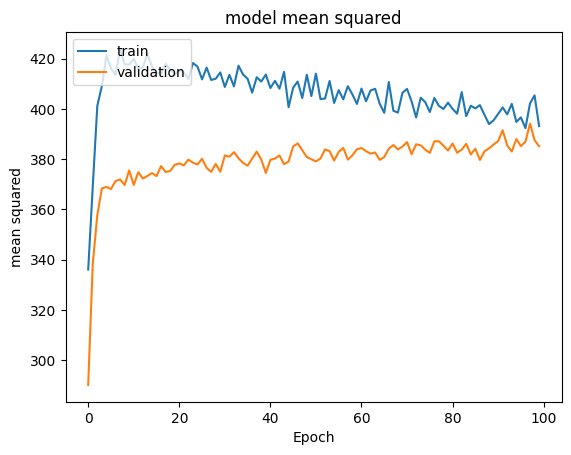

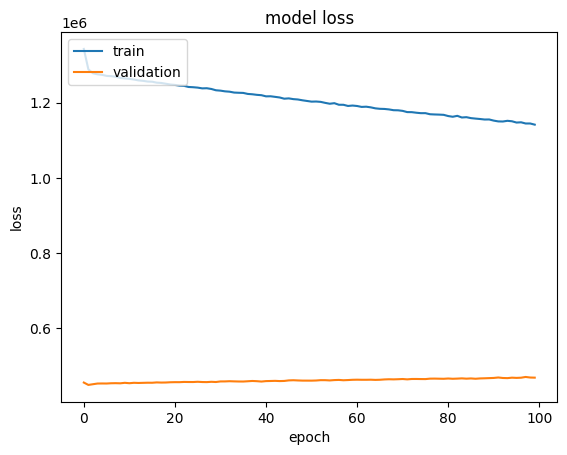

In [32]:
training_utils.history_metric_evaluation(dense_history, display_epochs)

In [33]:
model.evaluate(test_generator)

200/200 [==============================] - 30s 150ms/step - loss: 561582.1250 - mae: 447.6364


[561582.125, 447.6363525390625]

In [34]:
model.save('vgg16_()_dense.tf')

INFO:tensorflow:Assets written to: vgg16_()_dense.tf\assets


INFO:tensorflow:Assets written to: vgg16_()_dense.tf\assets


In [35]:

merged_model = keras.Model(inputs=conv_base.input, outputs=i_model(conv_base.output))
activate_fine_tuning_on_vgg_16(merged_model)
merged_model.compile(loss="mse", optimizer="adam", metrics=["mae"])
merged_model.summary()

Freezing layer input_3
Freezing layer block1_conv1
Freezing layer block1_conv2
Freezing layer block1_pool
Freezing layer block2_conv1
Freezing layer block2_conv2
Freezing layer block2_pool
Freezing layer block3_conv1
Freezing layer block3_conv2
Freezing layer block3_conv3
Freezing layer block3_pool
Freezing layer block4_conv1
Freezing layer block4_conv2
Freezing layer block4_conv3
Freezing layer block4_pool
Unfreezing layer block5_conv1
Unfreezing layer block5_conv2
Unfreezing layer block5_conv3
Unfreezing layer block5_pool
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 10, 512)        14714688  
                                                                 
 model_2 (Functional)        (None, 1)                 35

In [36]:
conv_history = merged_model.fit(train_generator,
                                epochs=epochs,
                                callbacks=callbacks_list,
                                validation_data=val_generator,
                                )

Epoch 1/100
284/284 [==============================] - 51s 177ms/step - loss: 1488810.8750 - mae: 406.5188 - val_loss: 539422.6250 - val_mae: 296.5348
Epoch 2/100
284/284 [==============================] - 50s 176ms/step - loss: 1413026.8750 - mae: 371.1977 - val_loss: 539318.0625 - val_mae: 296.3587
Epoch 3/100
284/284 [==============================] - 51s 177ms/step - loss: 1412889.0000 - mae: 371.0200 - val_loss: 539204.1250 - val_mae: 296.1663
Epoch 4/100
284/284 [==============================] - 50s 178ms/step - loss: 1412749.5000 - mae: 370.8282 - val_loss: 539095.1250 - val_mae: 295.9824
Epoch 5/100
284/284 [==============================] - 50s 177ms/step - loss: 1412608.3750 - mae: 370.6458 - val_loss: 538981.4375 - val_mae: 295.7901
Epoch 6/100
284/284 [==============================] - 50s 178ms/step - loss: 1412466.0000 - mae: 370.4472 - val_loss: 538866.1875 - val_mae: 295.5951
Epoch 7/100
284/284 [==============================] - 50s 178ms/step - loss: 1412323.7500 - m

In [37]:
global_history['vgg16_()_conv'] = conv_history

In [38]:
model.evaluate(test_generator)

200/200 [==============================] - 41s 203ms/step - loss: 561582.3750 - mae: 447.6366


[561582.375, 447.6365966796875]

In [39]:
model.save('vgg16_()_conv.tf')

INFO:tensorflow:Assets written to: vgg16_()_conv.tf\assets


INFO:tensorflow:Assets written to: vgg16_()_conv.tf\assets


In [40]:
print(f'Min mae: {np.min(conv_history.history["mae"])}')
print(f'Min val_mae: {np.min(conv_history.history["val_mae"])}')
print(f'Min loss: {np.min(conv_history.history["loss"])}')
print(f'Min val_loss: {np.min(conv_history.history["val_loss"])}')

Min mae: 353.8030700683594
Min val_mae: 279.2868957519531
Min loss: 1399491.375
Min val_loss: 528578.8125


Min mae: 353.8030700683594
Min val_mae: 279.2868957519531
Min loss: 1399491.375
Min val_loss: 528578.8125


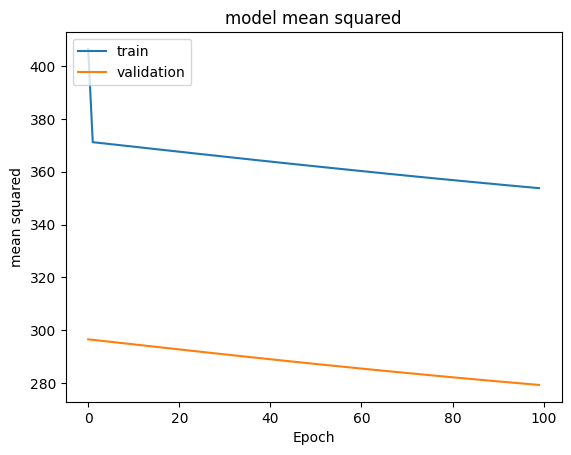

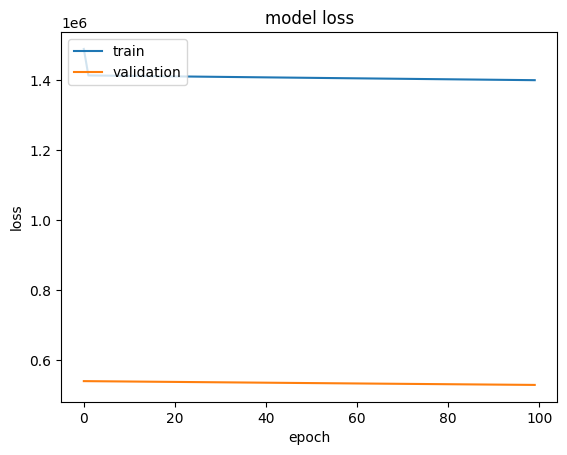

In [41]:
training_utils.history_metric_evaluation(conv_history, display_epochs)

In [42]:
i_model = output_vgg_16_layers(keras.Input(shape=feature_train.shape[1:]), [64])

i_model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [43]:
dense_history = i_model.fit(feature_train, train_df[1].values,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            validation_data=(feature_val, val_df[1].values),
                            )

Epoch 1/100
71/71 [==============================] - 1s 9ms/step - loss: 1288518.1250 - mae: 393.3616 - val_loss: 454290.9688 - val_mae: 370.2577
Epoch 2/100
71/71 [==============================] - 0s 6ms/step - loss: 1275313.0000 - mae: 425.1070 - val_loss: 451850.3125 - val_mae: 318.1670
Epoch 3/100
71/71 [==============================] - 0s 6ms/step - loss: 1267809.7500 - mae: 406.9878 - val_loss: 456142.5312 - val_mae: 376.1866
Epoch 4/100
71/71 [==============================] - 0s 6ms/step - loss: 1262966.6250 - mae: 408.9139 - val_loss: 455917.3125 - val_mae: 371.2119
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 1253277.6250 - mae: 412.7644 - val_loss: 457956.7812 - val_mae: 377.6702
Epoch 6/100
71/71 [==============================] - 0s 7ms/step - loss: 1246325.0000 - mae: 415.2069 - val_loss: 455389.0938 - val_mae: 358.8414
Epoch 7/100
71/71 [==============================] - 1s 7ms/step - loss: 1246354.5000 - mae: 408.9343 - val_loss: 459447.218

In [44]:
global_history['vgg16_(64)_dense'] = dense_history

Min mae: 174.63343811035156
Min val_mae: 318.1669921875
Min loss: 91013.125
Min val_loss: 451850.3125


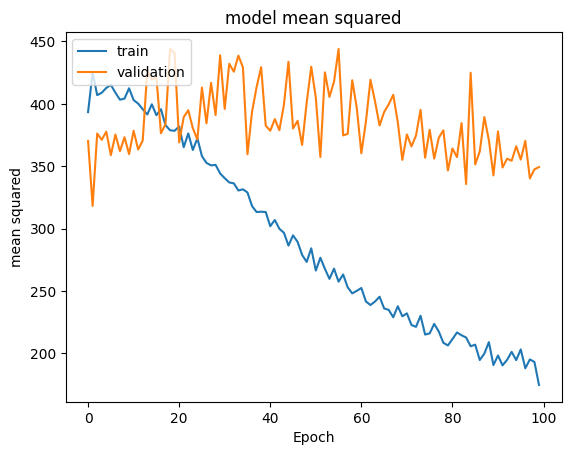

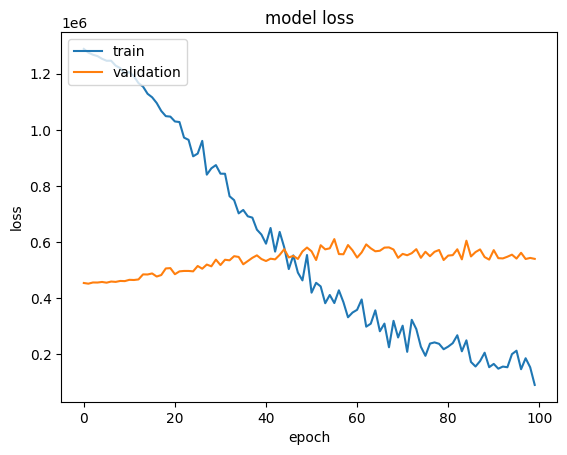

In [45]:
training_utils.history_metric_evaluation(dense_history, display_epochs)

In [46]:
model.evaluate(test_generator)

200/200 [==============================] - 31s 154ms/step - loss: 561582.1250 - mae: 447.6365


[561582.125, 447.63653564453125]

In [47]:
model.save('vgg16_(64)_dense.tf')

INFO:tensorflow:Assets written to: vgg16_(64)_dense.tf\assets


INFO:tensorflow:Assets written to: vgg16_(64)_dense.tf\assets


In [48]:

merged_model = keras.Model(inputs=conv_base.input, outputs=i_model(conv_base.output))
activate_fine_tuning_on_vgg_16(merged_model)
merged_model.compile(loss="mse", optimizer="adam", metrics=["mae"])
merged_model.summary()

Freezing layer input_3
Freezing layer block1_conv1
Freezing layer block1_conv2
Freezing layer block1_pool
Freezing layer block2_conv1
Freezing layer block2_conv2
Freezing layer block2_pool
Freezing layer block3_conv1
Freezing layer block3_conv2
Freezing layer block3_conv3
Freezing layer block3_pool
Freezing layer block4_conv1
Freezing layer block4_conv2
Freezing layer block4_conv3
Freezing layer block4_pool
Unfreezing layer block5_conv1
Unfreezing layer block5_conv2
Unfreezing layer block5_conv3
Unfreezing layer block5_pool
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 10, 512)        14714688  
                                                                 
 model_4 (Functional)        (None, 1)                 22

In [50]:
conv_history = merged_model.fit(train_generator,
                                epochs=epochs,
                                callbacks=callbacks_list,
                                validation_data=val_generator,
                                )

Epoch 1/100
284/284 [==============================] - 55s 191ms/step - loss: 1405179.7500 - mae: 360.6483 - val_loss: 530351.5625 - val_mae: 281.8175
Epoch 2/100
284/284 [==============================] - 51s 179ms/step - loss: 1397764.0000 - mae: 351.8806 - val_loss: 524005.5938 - val_mae: 273.4439
Epoch 3/100
284/284 [==============================] - 51s 178ms/step - loss: 1389077.1250 - mae: 343.2716 - val_loss: 516594.3125 - val_mae: 265.9355
Epoch 4/100
284/284 [==============================] - 51s 179ms/step - loss: 1379266.8750 - mae: 334.9837 - val_loss: 508838.6250 - val_mae: 260.6099
Epoch 5/100
284/284 [==============================] - 52s 184ms/step - loss: 1368885.6250 - mae: 329.5150 - val_loss: 501191.9688 - val_mae: 257.3876
Epoch 6/100
284/284 [==============================] - 31410s 111s/step - loss: 1359356.3750 - mae: 325.9944 - val_loss: 493615.0000 - val_mae: 256.2158
Epoch 7/100
284/284 [==============================] - 54s 190ms/step - loss: 1348783.3750 -

In [51]:
global_history['vgg16_(64)_conv'] = conv_history

Min mae: 323.6969909667969
Min val_mae: 256.2157897949219
Min loss: 1272437.375
Min val_loss: 451492.40625


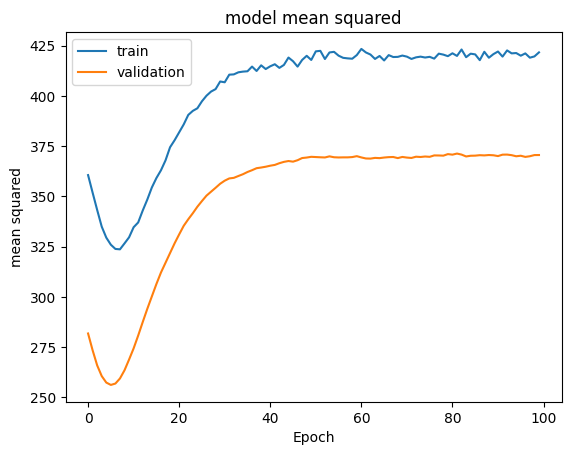

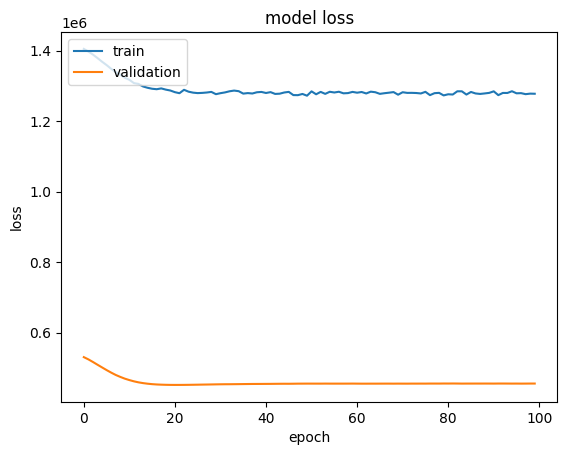

In [52]:
training_utils.history_metric_evaluation(conv_history, display_epochs)

In [53]:
model.evaluate(test_generator)

200/200 [==============================] - 35s 177ms/step - loss: 561582.3125 - mae: 447.6366


[561582.3125, 447.6365966796875]

In [54]:
model.save('vgg16_(64)_conv.tf')

INFO:tensorflow:Assets written to: vgg16_(64)_conv.tf\assets


INFO:tensorflow:Assets written to: vgg16_(64)_conv.tf\assets
